In [1]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

2024-07-16 07:01:27.827249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 07:01:27.827348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 07:01:28.117056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path = '/kaggle/input/skin-diseases-dermnet/Penyakit Kulit/Train'
val_path = '/kaggle/input/skin-diseases-dermnet/Penyakit Kulit/Validation'
test_path = '/kaggle/input/skin-diseases-dermnet/Penyakit Kulit/Test'

In [3]:
train_data = []

for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    file = os.listdir(folder_path)
    num_train = int(len(file))
    files_train = random.sample(file, num_train)
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2534 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [4]:
val_data = []

for folder in os.listdir(val_path):
    folder_path = os.path.join(val_path, folder)
    file = os.listdir(folder_path)
    num_train = int(len(file))
    files_val = random.sample(file, num_train)
          
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

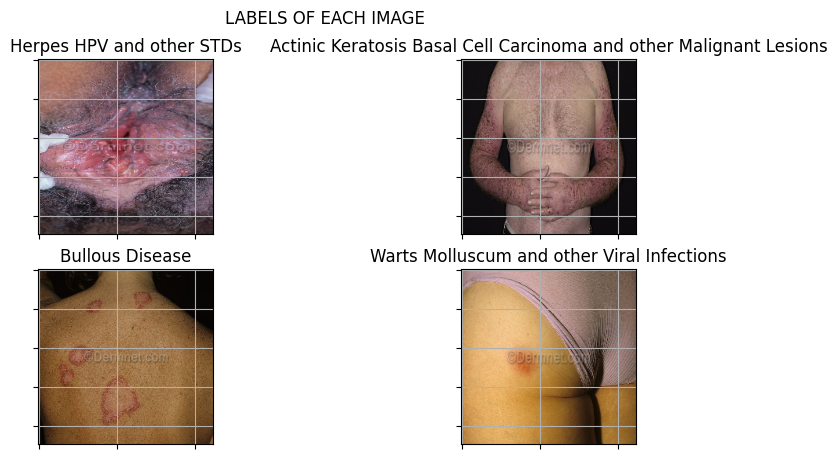

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 4), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

In [6]:
class_names = sorted(os.listdir(train_path))
num_classes = len(class_names)

img_size = (224, 224, 3)
print(class_names)

['Acne and Rosacea', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis', 'Bullous Disease', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue Diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and Related Diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


In [7]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=img_size)
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

80134624/80134624 [==============================] - 0s 0us/step


In [8]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# train_data = [(preprocess_input(input), label) for input, label in train_data]
# val_data = [(preprocess_input(input), label) for input, label in val_data]

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)

In [10]:
EPOCHS = 12
BATCH_SIZE = 32
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE)

model.save('/kaggle/working/VGG19.h5')

Epoch 1/12


I0000 00:00:1721113405.970017     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 [==============================] - 44s 228ms/step - loss: 3.1074 - accuracy: 0.2364 - val_loss: 1.9159 - val_accuracy: 0.4393
Epoch 2/12
138/138 [==============================] - 23s 169ms/step - loss: 1.8834 - accuracy: 0.4445 - val_loss: 1.4661 - val_accuracy: 0.5727
Epoch 3/12
138/138 [==============================] - 24s 176ms/step - loss: 1.4393 - accuracy: 0.5718 - val_loss: 1.0949 - val_accuracy: 0.6867
Epoch 4/12
138/138 [==============================] - 26s 186ms/step - loss: 1.1007 - accuracy: 0.6698 - val_loss: 0.8726 - val_accuracy: 0.7796
Epoch 5/12
138/138 [==============================] - 25s 179ms/step - loss: 0.8257 - accuracy: 0.7620 - val_loss: 0.6963 - val_accuracy: 0.8156
Epoch 6/12
138/138 [==============================] - 24s 176ms/step - loss: 0.6375 - accuracy: 0.8166 - val_loss: 0.5694 - val_accuracy: 0.8696
Epoch 7/12
138/138 [==============================] - 25s 179ms/step - loss: 0.4775 - accuracy: 0.8739 - val_loss: 0.4206 - val_accuracy: 0.9

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


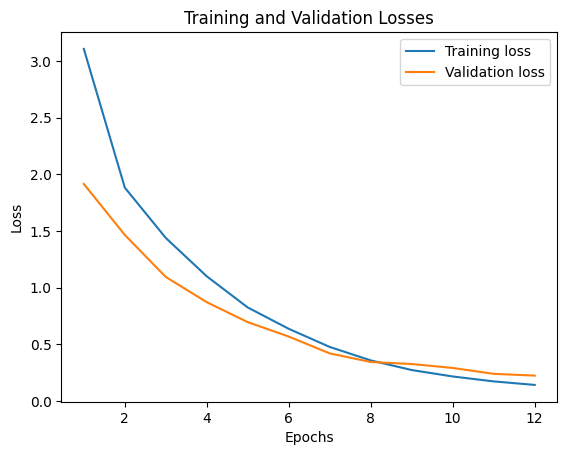

In [11]:
# Get the training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training loss' )
plt.plot(epochs, val_loss,label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

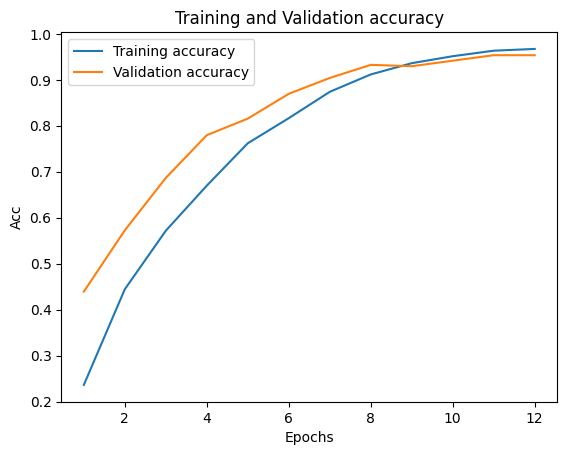

In [12]:
# Get the training and validation losses from the history object
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training accuracy')
plt.plot(epochs, val_loss,label='Validation accuracy',)
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

# Show the plot
plt.show()

In [13]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/VGG19.h5') 
real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img])) 

        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])

1/1 [==============================] - 0s 18ms/step


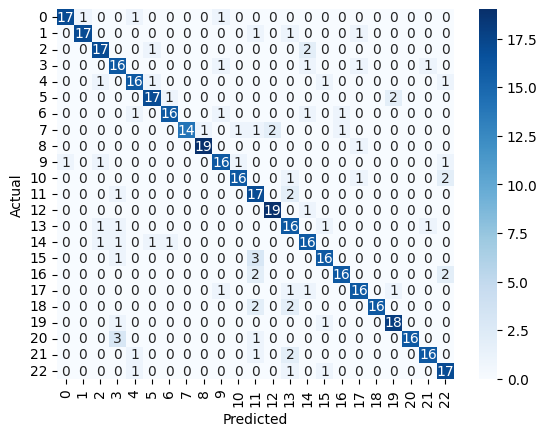

0.8260869565217391


In [14]:
from sklearn.metrics import confusion_matrix,accuracy_score
conf_matrix = confusion_matrix(real_label, predicted_class)
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(accuracy_score(real_label,predicted_class))

In [15]:
from sklearn.metrics import classification_report
print(classification_report(real_label, predicted_class))

                                                                    precision    recall  f1-score   support

                                                  Acne and Rosacea       0.94      0.85      0.89        20
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.94      0.85      0.89        20
                                                 Atopic Dermatitis       0.81      0.85      0.83        20
                                                   Bullous Disease       0.67      0.80      0.73        20
                Cellulitis Impetigo and other Bacterial Infections       0.80      0.80      0.80        20
                                                            Eczema       0.85      0.85      0.85        20
                                      Exanthems and Drug Eruptions       0.89      0.80      0.84        20
                 Hair Loss Photos Alopecia and other Hair Diseases       1.00      0.70      0.82        20
                           

In [16]:
# Load the model
model_path = '/kaggle/working/VGG19.h5'
model = load_model(model_path)

# Function for single image prediction
def predict_single_image(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(np.array([img]))

    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    
    return predicted_class_index

# Example usage
image_path = '/kaggle/input/skin-diseases-dermnet/Penyakit Kulit/Test/Acne and Rosacea/Acne and Rosacea_ (102).jpg'
predicted_class_index = predict_single_image(image_path, model)
predicted_class_label = le.classes_[predicted_class_index]
print("Predicted class index:", predicted_class_index)
print("Predicted class label:", predicted_class_label)

1/1 [==============================] - 0s 167ms/step
Predicted class index: 0
Predicted class label: Acne and Rosacea
